In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pwd()

'/mnt/e/ADITYA/EDUCATION/ML/Jupyter Lab/MNIST'

In [3]:
path='/mnt/e/ADITYA/EDUCATION/ML/Jupyter Lab/MNIST'

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]



In [4]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)  
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

In [10]:
def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

In [5]:
def forward_backward(x, y):
  # training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1

  # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)

  # training in numpy (super hard!)
  # backward pass

  # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y)

  # derivative of logsoftmax
  # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of l1
    d_l1 = x.T.dot(dx_l1)
  
    return x_loss, x_l2, d_l1, d_l2



loss 0.24 accuracy 0.18
loss 0.21 accuracy 0.23
loss 0.19 accuracy 0.50
loss 0.18 accuracy 0.38
loss 0.14 accuracy 0.60
loss 0.14 accuracy 0.53
loss 0.14 accuracy 0.56
loss 0.12 accuracy 0.63
loss 0.13 accuracy 0.55
loss 0.11 accuracy 0.65
loss 0.10 accuracy 0.66
loss 0.09 accuracy 0.71
loss 0.08 accuracy 0.77
loss 0.08 accuracy 0.75
loss 0.08 accuracy 0.74
loss 0.10 accuracy 0.68
loss 0.09 accuracy 0.72
loss 0.06 accuracy 0.79
loss 0.06 accuracy 0.85
loss 0.05 accuracy 0.86
loss 0.05 accuracy 0.86
loss 0.06 accuracy 0.77
loss 0.06 accuracy 0.81
loss 0.05 accuracy 0.84
loss 0.04 accuracy 0.87
loss 0.07 accuracy 0.79
loss 0.09 accuracy 0.71
loss 0.07 accuracy 0.81
loss 0.05 accuracy 0.87
loss 0.05 accuracy 0.87
loss 0.06 accuracy 0.82
loss 0.04 accuracy 0.89
loss 0.04 accuracy 0.91
loss 0.04 accuracy 0.87
loss 0.05 accuracy 0.86
loss 0.05 accuracy 0.85
loss 0.04 accuracy 0.89
loss 0.05 accuracy 0.84
loss 0.06 accuracy 0.85
loss 0.04 accuracy 0.89
loss 0.03 accuracy 0.95
loss 0.03 accura

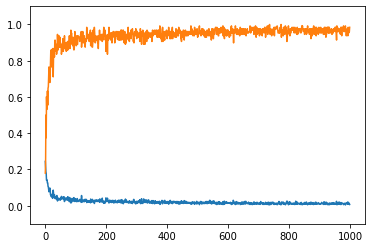

In [11]:
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in range(1000):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
    
  # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
  
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    print("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)
